# Stokes Gleichung (1D)

Berechnung eines 1-D Geschwindigkeitsprofiles einer Kanalströmung mit **konstantem** und **variablem** Tiefeviskositätsprofil.

## Einführung

Die Stokes Gleichung in einer Richtung (hier betrachten wir nur die x-Komponente) ist gegeben durch: 

$$
\begin{equation}
0 = -\frac{\partial{P}}{\partial{x}}+\frac{\partial}{\partial{x}}\left(\eta \left(\frac{\partial{v_x}}{\partial{y}}+\frac{\partial{v_y}}{\partial{x}}\right)\right). \tag{1}
\end{equation}
$$

<img src="../Figures/Exercise08_1.png" al7t="drawing" width="500"/> <br>

**Abb. 1. Kanalströmung.** **Couette**(Rot) und **Couette-Poisseuille**(Grün) Strömungsprofil einer Kanalströmung. Unter der Annahme eines konstanten Druckgradientens und lateral nicht variierender Vikosität lässt sich die Strömung im Kanal durch ein 1-D Profil angeben. 

&emsp; Nehmen wir an, die Strömung sei nur gegeben durch einen konstanten Druckgradienten und einer konstanten Geschwindigkeit an der Oberfläche (oder Boden, oder beidem), dann beschreibt die 1-D Stokes-Gleichung die Strömunggeschwindigkeit in einem horizontalem Kanal und ist gegeben durch (Abb. 1):  

$$
\frac{\partial{P}}{\partial{x}} = \frac{\partial{\tau_{x,y}}}{\partial{y}}, \tag{2}
$$

wobei *P* der Druck und $\tau_{x,y}$ die deviatorischer Scherspannung sind. Die Scherspannung ist definiert durch: 

$$
\tau_{x,y} = 2 \eta \dot{\varepsilon}_{x,y}, \tag{3}
$$

wobei $\eta$ die dynamische Viscosität und $\dot{\varepsilon}_{x,y}$ die deviatorische Scherdehnungsrate sind, wobei letztere gegeben ist durch: 

$$
\dot{\varepsilon}_{x,y} = \frac{1}{2}\frac{\partial{v_x}}{\partial{y}}. \tag{4}
$$

In Abhängigkeit der Unbekannten lässt sich Gleichung $(2)$ umformulieren zu: 

$$
\frac{\partial{P}}{\partial{x}} = \frac{\partial}{\partial{x}}\left(\eta\left(\frac{\partial{v_x}}{\partial{y}}\right)\right). \tag{5}
$$

Die Annahme einer konstant Viskosität vereinfacht Gleichung $(5)$ weiter in eine Poissongleichung der Form: 

$$
\frac{\partial{P}}{\partial{x}} = \eta\frac{\partial^2{v_x}}{\partial{y}^2}. \tag{6}
$$

Unter der Annahme einer bekannten Viskosität und eines horizontalen Druckgradienten kann mann die Gleichungen $(5)$ und $(6)$ numerisch oder analytisch lösen. Dies hat den Vorteil, dass wir die Genauigkeit der numerischen Lösung exakt testen können. Nehmen wir zum Beispiel an, die Viskosität variiere logerithmisch mit der Tiefe und sei gegeben durch:   

$$
\eta = \eta_0 exp\left(-log(m) \frac{y}{H}\right), \tag{7}
$$
<!-- Needs to be checked! -->
wobei *m* das Viskositätsverhältnis von $\frac{\eta_1}{\eta_0}$ ist, $\eta_0$ und $\eta_1$ sind jeweils die Viskositäten and der Ober- und Unterseite, *H* ist die Schichtdicke, und *y* ist die Tiefe (negative nach unten). Durch zweifache Integration der Gleichung $(5)$ können wir eine analytische Lösung der horizontalen Flussgeschwindigkeit in x-Richtung herleiten. Die tiefenabhängige analyitische Lösung hängt ab von dem Viskositätsverhältnis *m*, dem horizontalen Druckgradienten $\frac{\partial{P}}{\partial{x}}$, und der Schergeschwindigkeit an der Oberseite $v_{x,0}$ und ist gegeben durch:  

$$
v_{x,ana}(y) =\frac{1}{2 \eta_0} \frac{\partial P}{\partial{x}} \left(y^2 + Hy\right) + v_{x,0}\frac{y}{H} + v_{x,0} ;\ \textrm{falls}\ m = 1, \tag{8}
$$

und

$$
v_{x,ana}(y) = 
-\frac{1}{\eta_0}\frac{\partial{P}}{\partial{x}}\frac{H}{log(m)(m-1)} \left(-y\left(m^{(y+H)/H}-m^{y/H}\right) + H\left(m^{y/H}-1\right)\right)+\frac{v_{x0}}{m-1}\left(m^{(y+H)/H}-1\right);\ \textrm{falls}\ m \neq 0, \tag{9}
$$.

## Lösung
### Diskretisierung
Zur Lösung des Problems, müssen wir die PDGn wieder durch finite Differenzen approximieren. Dazu teilen wir das 1-D Profil in ein numerisches 1-D Gitter auf (Abb. 2). 

<img src="../Figures/Exercise08_2.png" al7t="drawing" width="250"/> <br>

**Abb. 2. Diskretisierung.** Eindimensionale finite Differenzen Aufteilung für die horizontale Geschwindigkeit (Cyan) und die Viskosität (Schwarz). Für eine tiefenabhängige Viskosität muss diese auf den Vertices (*nv*) und die Geschwindigkeit auf den Centroids (*nc*) definiert werden. 

Zur Lösung der PDG müssen wir die Gleichungen $(5)$ und $(6)$ mit Hilfe von finiten Differenzen Operatoren approximieren. Das zu lösende Gleichungssystem für beide Fälle, konstanter oder variabler Viskosität, ist das gleiche und gegeben durch: 

$$
\frac{\partial{P}}{\partial{x}} = a v_{x,j-1} + b v_{x,j} + c v_{x,j+1}, \tag{10}
$$

wobei für eine **konstante Viskosität** die Koeffizienten gegeben sind durch (Diskretisierung von Gleichung $(6)$ ): 

$$
a = c = \frac{\eta}{\Delta{y}^2}, \ \textrm{und}\ b = -\frac{2\eta}{\Delta{y\^2}}. \tag{11}
$$

Im Falle einer **variablen Viskosität** müssen wir Gleichung $(5)$ diskretisieren und nutzen die versetzten (staggered) Gitterpunkte. Dabei ist die Geschwindigkeit auf den *Centroids* definiert und die Viskosität auf den *Vertices* (Abb. 2). Die Diskretisierung von Gleichung $(5)$ sie dann wie folgt aus (beachte die unterschiedlichen Indizierungen (Abb. 2)): 

$$
\frac{\partial{P}}{\partial{x}} = \frac{\eta_{j+1} \frac{\partial{v_x}}{\partial{y}}\vert_{j+1} - \eta_{j} \frac{\partial{v_x}}{\partial{y}}\vert_{j}}{\Delta{y}}, \tag{12}
$$

$$
\frac{\partial{P}}{\partial{x}} = \frac{\eta_{j+1} \frac{v_{x,j+1}-v_{x,j}}{\Delta{y}} - \eta_{j} \frac{v_{x,j}-v_{x,j-1}}{\Delta{y}}}{\Delta{y}}, \tag{13}
$$

$$
\frac{\partial{P}}{\partial{x}} = \frac{\eta_{j}}{\Delta{y}^2}v_{x,j-1} - \left(\frac{\eta_j+\eta_{j+1}}{\Delta{y}^2}\right)v_{x,j} + \frac{\eta_{j+1}}{\Delta{y}^2}v_{x,j+1}. \tag{14}
$$

Gleichung $(14)$ entspricht Gleichung $(10)$, wobei 

$$
a = \frac{\eta_j}{\Delta{y}^2},\ b = -\frac{\eta_j+\eta_{j+1}}{\Delta{y}^2},\ \textrm{und}\ c = \frac{\eta_{j+1}}{\Delta{y}^2}. \tag{15}
$$

### Randbedingungen

Für die Randbedingungen der Geschwindigkeit and der Ober- und Unterseite benutzten wir die zwei klassischen Randbedingungen, *Dirichlet* oder *Neumann*, d.h. konstante Geschdindigkeiten oder konstante Flussbedingungen. 

Zur Einbindung der Randbedingungen in unser lineares Gleichungssystem benutzen wir wieder die *Geister Knotenpunkte*, diesmal der Geschwindigkeit. Um das lineare Gleichungssystem direkt lösen zu können, müssen wir die Koeffizieten der Matrix und die entsprechende Werte der rechten Seite verändern. 

Die Geschwindigkeiten der *Geister Knotenpunkte* für die jeweilige Randbedingunge sind gegeben durch: 

**Dirichlet**

*Unten* (j=1)

$$
V_{G,S} = 2 V_{BC,S} - v_{x,1}, \tag{16}
$$

*Oben* (j=nc)

$$
V_{G,N} = 2 V_{BC,N} - v_{x,nc}, \tag{17}
$$

wobei $V_{BC,S}$ und $V_{BC,N}$ die Geschwindigkeiten an den Rändern sind und

**Neumann**

*Unten* (j=1)

$$
V_{G,S} = v_{x,1} - c_S \Delta{y}, \tag{18}
$$

*Oben* (j=nc)

$$
V_{G,N} = v_{x,nc} + c_N \Delta{y}, \tag{19}
$$

wobei $c_S$ und $c_N$ die vertikale Geschwindigkeitsgradienten $\frac{\partial{v_x}}{\partial{y}}$ über den jeweiligen Rand hinweg sind. 

Die Koeffizienten und die rechte Seite ändern sich dann entsprechend zu: 

**Dirichlet**

*unten* (j = 1)

$$
\left(b-a\right) v_{x,1} + c v_{x,2} = \frac{\partial{P}}{\partial{x}} - 2aV_{BC,S},
$$

*oben* (j=nc)

$$
a v_{x,nc-1} + \left(b-c\right) v_{x,nc}  = \frac{\partial{P}}{\partial{x}} - 2cV_{BC,N},
$$

**Neumann**

*unten* (j = 1)

$$
\left(b+a\right) v_{x,1} + c v_{x,2} = \frac{\partial{P}}{\partial{x}} + a c_S \Delta{y},
$$

*oben* (j=nc)

$$
a v_{x,nc-1} + \left(b+c\right) v_{x,nc}  = \frac{\partial{P}}{\partial{x}} - c c_N \Delta{y}.
$$

Nun laden wir erst einmal die notwendigen Module: 

In [1]:
using Plots, ExtendableSparse
start = time()

1.769672814772165e9

Nehmen wir nun an, die Schicht $H$ sei 400 km mächtig, die Geschwindigkeit an der Oberfläche $V_{x0}$ beträge 5 cm/a, die Referenzviskosität $\eta_0$ beträgt $10^{21}\ Pa\cdot s$, und der Druckgradient $\frac{\partial{P}}{\partial{x}}$ sei erst einmal gleich null.

In [2]:
# Model Parameter ------------------------------------------------------- #
M   =   (
    ymin        =   -400.0e3,           #   Tiefe [ m ]
    ymax        =   0.0e3,              
)
I   =   (
    vₓ₀         =   5/100/31536000,     #   Geschwindigkeit oben [ m/s ]
    η₀          =   1.0e21,             #   Viscosität an der Oberseite [ Pa s ]
    η₁          =   1.0e21,             #   Viskosität an der Unterseite [ Pa s ]
    ∂P∂x        =   -2.0e1,              #   horizontaler Druckgradient [ Pa/m ]
)
I1  =   (
    m           =   I.η₁ / I.η₀,        #   Viskositätsverhältnis
)
I   =   merge(I,I1)
# ----------------------------------------------------------------------- #

(vₓ₀ = 1.5854895991882295e-9, η₀ = 1.0e21, η₁ = 1.0e21, ∂P∂x = -20.0, m = 1.0)

Als nächstes definieren wir das numerische "Gitter" und den Speicher der Felder der Variablen:

In [3]:
# Numerische Parameter -------------------------------------------------- #
NC  =   (
    y   =   100,        #   Anzahl der vertikalen Centroids
)
NV  =   (
    y   =   NC.y + 1,
)
Δ   =   (
    y   =   (M.ymax-M.ymin)/NC.y,   #   Gitterauflösung
)
# ----------------------------------------------------------------------- #
# Speicherzuweisung ----------------------------------------------------- #
D   =   (
    η   =   zeros(NC.y+1),
    vₓ  =   zeros(NC...),
    vₓₐ =   zeros(NC...),
    Δvₓ =   zeros(NC...)
)
# ----------------------------------------------------------------------- #
# Gitter ---------------------------------------------------------------- #
y   =   (
    c   =   LinRange(M.ymin+Δ.y/2,M.ymax-Δ.y/2,NC.y),
    v   =   LinRange(M.ymin,M.ymax,NV.y),
)
# Viskositätsprofil ---
@. D.η  =   I.η₀ * exp(-log(I.m)* y.v / (M.ymax-M.ymin))
# ----------------------------------------------------------------------- #

101-element Vector{Float64}:
 1.0e21
 1.0e21
 1.0e21
 1.0e21
 1.0e21
 1.0e21
 1.0e21
 1.0e21
 1.0e21
 1.0e21
 ⋮
 1.0e21
 1.0e21
 1.0e21
 1.0e21
 1.0e21
 1.0e21
 1.0e21
 1.0e21
 1.0e21

Nun können wir auch die analytische Lösung mit Hilfe von Gleichungen $(8)$ und $(9)$ definieren: 

In [4]:
# Analytische Lösung ---------------------------------------------------- #
if I.m  == 1.0
    @. D.vₓₐ    =   1.0/2.0/I.η₀ * I.∂P∂x * 
                    (y.c^2 + (M.ymax-M.ymin).*y.c) + 
                    I.vₓ₀*y.c/(M.ymax-M.ymin) + I.vₓ₀
else
    @. D.vₓₐ    =   -I.∂P∂x * (M.ymax-M.ymin) / I.η₀ / log(I.m) / (I.m-1) * 
        (-y.c * (I.m^((y.c + (M.ymax-M.ymin))/(M.ymax-M.ymin)) - 
        I.m^(y.c/(M.ymax-M.ymin))) + (M.ymax-M.ymin)*(I.m^(y.c/(M.ymax-M.ymin)) - 1)) + 
        I.vₓ₀ / (I.m-1) * (I.m ^ ((y.c+(M.ymax-M.ymin))/(M.ymax-M.ymin)) - 1)
end
# ----------------------------------------------------------------------- #

100-element Vector{Float64}:
 1.588744799594119e-11
 4.742234398782337e-11
 7.863723997970591e-11
 1.0953213597158798e-10
 1.401070319634706e-10
 1.7036192795535256e-10
 2.0029682394723487e-10
 2.2991171993911733e-10
 2.5920661593099973e-10
 2.881815119228821e-10
 ⋮
 1.57516298325723e-9
 1.5775778792491122e-9
 1.5796727752409946e-9
 1.5814476712328768e-9
 1.582902567224759e-9
 1.5840374632166414e-9
 1.5848523592085237e-9
 1.585347255200406e-9
 1.5855221511922884e-9

Als Randbedingungen setzten wir an der Ober- (N) und Unterseite (S) Dirichlet Geschwindigkeitsbedingungen: 

In [5]:
# Randbedingungen ------------------------------------------------------- #
VBC     =   (
    type    = (S=:Dirichlet, N=:Dirichlet),
    val     = (S=0.0,N=I.vₓ₀)
)
# ----------------------------------------------------------------------- #

(type = (S = :Dirichlet, N = :Dirichlet), val = (S = 0.0, N = 1.5854895991882295e-9))

Nun definieren wir die Teile unseres linearen Gleichungssystems (Koeffizientenmatrix, rechte Seite). 

In [6]:
# Lineares Gleichungssystem --------------------------------------------- #
Num     =   (Vx=1:NC.y,)
ndof    =   maximum(Num.Vx)
K       =   ExtendableSparseMatrix(ndof,ndof)
rhs     =   zeros(NC...)
# ----------------------------------------------------------------------- #
# Zusammenstellen der Koeffizientenmatrix ------------------------------- #
#a       =     I.η₀ / Δ.y^2.0 = c
#b       =   - 2.0 * I.η₀ / Δ.y^2.0
rhs     .=  I.∂P∂x
for i = 1:NC.y
    a   =   D.η[i] / Δ.y^2.0
    b   =   -(D.η[i]+D.η[i+1]) / Δ.y^2.0
    c   =   D.η[i+1] / Δ.y^2.0
    # Gleichungsnummer ---
    ii  =   Num.Vx[i]
    # Stempel ---
    iN  =   ii + 1      #   Norden
    iC  =   ii          #   Zentral
    iS  =   ii - 1      #   Süden
    # Ränder ---
    # Falls ein Süd Index gebrauch wird ---
    inS    =  i==1    ? false  : true
    DirS   = (i==1    && VBC.type.S==:Dirichlet) ? 1. : 0.
    NeuS   = (i==1    && VBC.type.S==:Neumann  ) ? 1. : 0.
    # If an East index is required ---
    inN    =  i==NC.y ? false  : true
    DirN   = (i==NC.y && VBC.type.N==:Dirichlet) ? 1. : 0.
    NeuN   = (i==NC.y && VBC.type.N==:Neumann  ) ? 1. : 0.
    if inS K[ii,iS]    = a end
        K[ii,iC]       =   b + (NeuS - DirS)*a + (NeuN - DirN)*c
    if inN K[ii,iN]    = c end    
    # Änderung der rechten Seite ---
    rhs[i]      +=  a*VBC.val.S*Δ.y * NeuS - 
                        2*a*VBC.val.S * DirS - 
                        c*VBC.val.N*Δ.y * NeuN - 
                        2*c*VBC.val.N * DirN
end
# ----------------------------------------------------------------------- #

Jetzt lässt sich das Gleichungssystem lösen und wir können die Abweichung der numersichen Lösung von der analytischen Lösung bestimmen: 

In [7]:
# Lösung des Gleichungssystems ------------------------------------------ #
D.vₓ      .=   K \ rhs
# ----------------------------------------------------------------------- #
# Abweichung vom der analytischen Lösung -------------------------------- #
@. D.Δvₓ    =   ((D.vₓₐ - D.vₓ) / D.vₓₐ) * 100.0
# ----------------------------------------------------------------------- #

100-element Vector{Float64}:
 -0.2517710837516955
 -0.08434842446859557
 -0.05086648515348403
 -0.03651896280906472
 -0.028549601999508897
 -0.02347942435209681
 -0.019970361591658145
 -0.01739798215121521
 -0.015431704879390426
 -0.01388014093314767
  ⋮
 -0.0025394197568297107
 -0.0025355325100371567
 -0.0025321699928404708
 -0.0025293280787941626
 -0.002527003293087507
 -0.002525192801887194
 -0.0025238944036473135
 -0.0025231065224937035
 -0.0025228282033051487

Zum Schluss, visualisieren wir die Lösung und die Abweichung in einem Plot:

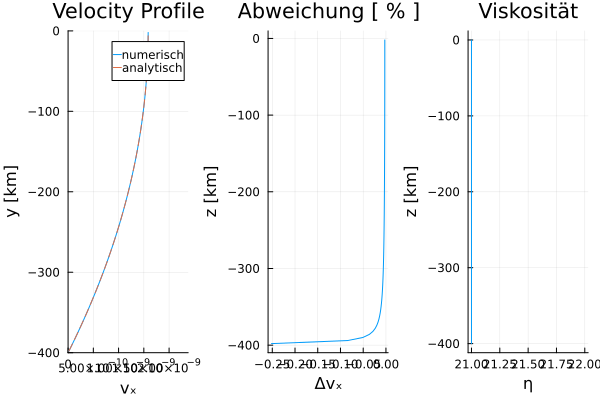

12.279181957244873


In [8]:
# Visualisierung -------------------------------------------------------- #
q   =   plot(D.vₓ,y.c./1e3,label="numerisch",
            xlabel="vₓ", ylabel="y [km]",
            title="Velocity Profile",
            xlim=(0,I.vₓ₀*1.5),ylim=(M.ymin/1e3,M.ymax/1e3),
            layout=(1,3),subplot=1)
plot!(q,D.vₓₐ,y.c./1e3,label="analytisch",linestyle=:dash,
        subplot=1)
plot!(q,D.Δvₓ,y.c./1e3,label="",
        xlabel="Δvₓ",ylabel="z [km]",
        title="Abweichung [ % ]",
        subplot=2)
plot!(q,log10.(D.η),y.v./1e3,label="",
        xlabel="η",ylabel="z [km]",
        title="Viskosität",
        subplot=3)
display(q)
# ----------------------------------------------------------------------- #

savefig("./Results/08_1D_Stokes.png")
stop=time()
println(stop-start)